<a href="https://colab.research.google.com/github/Roopg/BreastCancer_Segmentation_DeepLearningProject/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Breast Lesion Segmentation and Classification Model**

Based on U-Net Architecture
Built in Python and trained in Google Colab




**Installing Packages**

In [ ]:
!pip install tensorflow==2.4.0
!pip install keras==2.4.3
!pip install pydicom
!pip install scikit-learn
!pip install segmentation-models
!pip install import-ipynb
!pip install opencv-python
!pip install h5py==2.10.0


**Importing Required Libraries and Modules**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal

import glob
import cv2  #to open images
import os # to navigate through folders and directories
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import random
from scipy.ndimage import rotate
import albumentations as A  
from tqdm import tqdm  # shows the progress bar
from skimage.io import imread,imshow
from skimage.transform import resize, rescale
from sklearn.preprocessing import normalize
from PIL import Image # for resizing the images
import shutil #The shutil module offers a number of high-level operations on files and collections of files such as file copying and removal. 
from pathlib import Path
import pydicom as pydicom
from skimage import io

**Data Analysis using the CSV files in the CBIS-DDSM Dataset.**
Dataset: 
CBIS-DDSM :https://www.kaggle.com/awsaf49/cbis-ddsm-breast-cancer-image-dataset?select=jpeg 
or https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM (DICOM-format)

The dataset comes with 4 csv files- mass_train, mass_test, calcification_train, cacification_test. These csv files contain all the details about type of-

Abnormality in the breast- such as Calcification or Mass,  
Pathology(benigh, malignant),  
Image and mask file paths, 
View of the mammogram- MLO or CC, 
Side of the breast- Right or Left 

Each mammogram image has a corresponding ground truth mask and identified by a unique patient id. Each patient mammogram record has 4 typically 4 image files along with the ground truth mask image.

P_0001_LEFT_CC, 
P_0001_RIGHT_CC, 
P_0001_LEFT_MLO, 
P_0001_RIGHT_MLO


In [ ]:
#Analyze the dataset and Combine all 4 CSV files into single file #

DATA_PATH  = Path("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data")
MASS_TRAIN = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_train_set.csv"
MASS_TEST  = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_test_set.csv"
CALC_TRAIN = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/calc_case_description_train_set.csv"
CALC_TEST  = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/calc_case_description_test_set.csv"


#Add a subset column to remember the original split

mass_train_df = pd.read_csv(DATA_PATH/MASS_TRAIN)
mass_train_df['subset'] = 'train'

mass_test_df = pd.read_csv(DATA_PATH/MASS_TEST)
mass_test_df['subset'] = 'test'

calc_train_df = pd.read_csv(DATA_PATH/CALC_TRAIN)
calc_train_df['subset'] = 'train'

calc_test_df = pd.read_csv(DATA_PATH/CALC_TEST)
calc_test_df['subset'] = 'test'

#COMBINED ALL 4 CSV FILES INTO A PANDAFRAME

data_df = pd.concat([mass_train_df, calc_train_df, mass_test_df, calc_test_df], sort=False).reset_index()
data_df.info()

COLS = ["patient_id", "left or right breast", "image view", "abnormality id", "abnormality type", "pathology", "image file path", "ROI mask file path", "cropped image file path", "subset"]
data_df = data_df[COLS]
data_df.head()
data_df.to_csv(DATA_PATH/"all_data.csv", index=False)
#data_df.to_csv("/content/drive/MyDrive/BC_Tumor_Segmentation_data/all_data.csv", index=True)
data_df.head()


print("# unique patients", len(data_df['patient_id'].unique()))
print("# abnormality type", len(data_df['abnormality type'].unique()), data_df['abnormality type'].unique())
print("# image view", len(data_df['image view'].unique()), data_df['image view'].unique())
print("# pathologies", len(data_df['pathology'].unique()), data_df['pathology'].unique())


_df = data_df[['patient_id', 'abnormality type']].drop_duplicates().groupby('abnormality type').count()
ax = _df.unstack('abnormality type').plot(kind='bar', figsize=(7, 5))
ax.set_title("Nr of patients for each abnormality type", fontsize=14)
ax.set_xlabel("Abnormality type", fontsize=14)
ax.set_xticklabels(_df.index)
ax.set_ylabel("Nr of patients", fontsize=14)


_df = data_df[['patient_id', 'subset']].drop_duplicates().groupby('subset').count()
ax = _df.unstack('subset').plot(kind='bar', figsize=(7, 5))
ax.set_title("Nr of patients in each subset", fontsize=14)
ax.set_xlabel("Subset", fontsize=14)
ax.set_xticklabels(_df.index)
ax.set_ylabel("Nr of patients", fontsize=14)


COLS = ["patient_id", "left or right breast", "image view", "abnormality id", "abnormality type", "pathology", "image file path", "ROI mask file path", "cropped image file path", "subset"]
data_df = data_df[COLS]
data_df.head()
data_df.to_csv(DATA_PATH/"all_data.csv", index=False)





In [ ]:
####MASS#####

import pandas as pd
MASS_TRAIN = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_train_set.csv"
MASS_TEST  = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_test_set.csv"

# df = pd.read_csv(MASS_TRAIN)
# # Rename columns
# new_cols = [col.replace(" ", "_") for col in df.columns]
# df.columns = new_cols
# #df = df.loc[df["patient_id"].isin(["P_01039"])]
# df = df.loc[df["abnormality_id"] > 1]
# df

df = pd.read_csv(MASS_TEST)
# Rename columns
new_cols = [col.replace(" ", "_") for col in df.columns]
df.columns = new_cols
#df = df.loc[df["patient_id"].isin(["P_01039"])]
df = df.loc[df["abnormality_id"] > 1]
df

### **Creating a combined "all.csv" file and formatting the column names etc.**

In [ ]:
# Combining and creating a csv for complete Calc_Test and Train#
import numpy as np

MASS_TRAIN = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_train_set.csv"
MASS_TEST  = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/mass_case_description_test_set.csv"

CALC_TRAIN = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/calc_case_description_train_set.csv"
CALC_TEST  = "/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/calc_case_description_test_set.csv"

mass_train_df = pd.read_csv(MASS_TRAIN)
mass_test_df = pd.read_csv(MASS_TEST)

mass_all_df = pd.concat(objs=[mass_train_df, mass_test_df])
mass_all_df.head()

#Remove spaces in columns name
mass_all_df.columns = mass_all_df.columns.str.replace(' ','_')
mass_all_df.head()

mass_all_df['pathology'] =mass_all_df['pathology'].replace({'BENIGN_WITHOUT_CALLBACK':'BENIGN'})

# Drop path columns
mass_all_df.drop(columns=["image_file_path", "cropped_image_file_path", "ROI_mask_file_path"], inplace=True)

# Create identifier column for calc
mass_all_df.insert(loc=0, column="identifier", value=np.nan)
mass_all_df["identifier"] = mass_all_df.apply(lambda x: "_".join([x["patient_id"], x["left_or_right_breast"], x["image_view"]]), axis=1) #creating a unique identifier for the file names

#####calc#####

calc_train_df = pd.read_csv(CALC_TRAIN)
calc_test_df = pd.read_csv(CALC_TEST)

calc_all_df = pd.concat(objs=[calc_train_df, calc_test_df])

# Remove spaces in columns name
calc_all_df.columns = calc_all_df.columns.str.replace(' ','_')

calc_all_df['pathology'] =calc_all_df['pathology'].replace({'BENIGN_WITHOUT_CALLBACK':'BENIGN'})
# Drop path columns
calc_all_df.drop(columns=["image_file_path", "cropped_image_file_path", "ROI_mask_file_path"], inplace=True)

# Create identifier column for calc
calc_all_df.insert(loc=0, column="identifier", value=np.nan)
calc_all_df["identifier"] = calc_all_df.apply(lambda x: "_".join([x["patient_id"], x["left_or_right_breast"], x["image_view"]]), axis=1)


print(mass_all_df.shape)
print(calc_all_df.shape)
print(len(mass_all_df["identifier"].unique()))
print(len(calc_all_df["identifier"].unique()))
calc_all_df.head()
mass_all_df.head(50)

## **Removal of cases with both mass and calficiation abnormalities**

In [ ]:

#There are 71 Patient IDs with both mass and calc abnormalities, so we can remove them 

calc_set = set(calc_all_df["identifier"].unique())
mass_set = set(mass_all_df["identifier"].unique())

both_set = calc_set.intersection(mass_set)
len(both_set)

71

In [ ]:
all_df=pd.concat([mass_all_df,calc_all_df], sort=False).reset_index()
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 3568 non-null   int64 
 1   identifier            3568 non-null   object
 2   patient_id            3568 non-null   object
 3   breast_density        3568 non-null   int64 
 4   left_or_right_breast  3568 non-null   object
 5   image_view            3568 non-null   object
 6   abnormality_id        3568 non-null   int64 
 7   abnormality_type      3568 non-null   object
 8   mass_shape            1692 non-null   object
 9   mass_margins          1636 non-null   object
 10  assessment            3568 non-null   int64 
 11  pathology             3568 non-null   object
 12  subtlety              3568 non-null   int64 
 13  calc_type             1848 non-null   object
 14  calc_distribution     1433 non-null   object
dtypes: int64(5), object(10)
memory usage: 

**Visualize the Pathology distribution in the dataset**

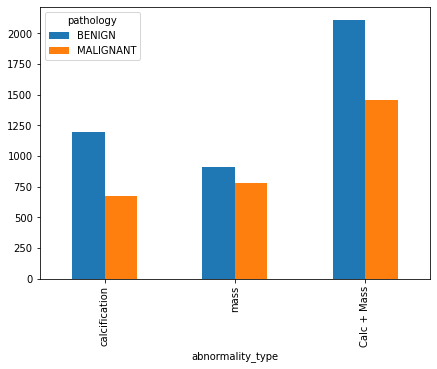

In [ ]:
#Pathology- Benign and Malignant#

import matplotlib.pyplot as plt
plot_df = all_df.groupby(["abnormality_type"])["pathology"].value_counts().unstack()
new_row = plot_df.loc["calcification"] + plot_df.loc["mass"]
new_row.name = "Calc + Mass"
plot_df = plot_df.append(new_row, ignore_index=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
plot_df.plot.bar(ax=ax)

In [ ]:
# Get identifiers that have both calcification and mass abnormalities.
# --------------------------------------------------------------------

# Create dictionary of identifiers.
iden_list = list(all_df["identifier"].unique())
iden_dict = dict((iden, []) for iden in iden_list)

# Loop through all_df and get calcification or mass type.
for row in all_df.itertuples():
    
    iden = row.identifier
    ab_type = row.abnormality_type
    
    if ab_type not in iden_dict[iden]:
        iden_dict[iden].append(ab_type)
    
# Check for identifiers with >1 type.
both_iden = []
for k, v in iden_dict.items():
    
    if len(v) > 1:
        both_iden.append(k)
        
print(both_iden)

for iden in both_iden:
    del iden_dict[iden]

all_df.to_csv('all_data.csv',index=False)

['P_00034_RIGHT_CC', 'P_00034_RIGHT_MLO', 'P_00041_LEFT_CC', 'P_00041_LEFT_MLO', 'P_00106_RIGHT_CC', 'P_00106_RIGHT_MLO', 'P_00208_RIGHT_MLO', 'P_00224_LEFT_CC', 'P_00224_LEFT_MLO', 'P_00385_RIGHT_CC', 'P_00385_RIGHT_MLO', 'P_00495_RIGHT_CC', 'P_00495_RIGHT_MLO', 'P_00522_RIGHT_MLO', 'P_00539_RIGHT_CC', 'P_00539_RIGHT_MLO', 'P_00573_RIGHT_MLO', 'P_00666_RIGHT_CC', 'P_00666_RIGHT_MLO', 'P_00673_RIGHT_MLO', 'P_00678_LEFT_CC', 'P_00710_RIGHT_CC', 'P_00710_RIGHT_MLO', 'P_00723_LEFT_MLO', 'P_00734_RIGHT_MLO', 'P_00814_LEFT_CC', 'P_00814_LEFT_MLO', 'P_00847_LEFT_MLO', 'P_00906_LEFT_CC', 'P_00906_LEFT_MLO', 'P_01084_LEFT_CC', 'P_01084_LEFT_MLO', 'P_01152_RIGHT_CC', 'P_01152_RIGHT_MLO', 'P_01179_LEFT_MLO', 'P_01262_RIGHT_CC', 'P_01262_RIGHT_MLO', 'P_01274_RIGHT_MLO', 'P_01297_LEFT_CC', 'P_01297_LEFT_MLO', 'P_01454_LEFT_MLO', 'P_01517_LEFT_MLO', 'P_01567_LEFT_MLO', 'P_01573_RIGHT_CC', 'P_01573_RIGHT_MLO', 'P_01635_RIGHT_CC', 'P_01635_RIGHT_MLO', 'P_01725_RIGHT_CC', 'P_01725_RIGHT_MLO', 'P_01803

**Code to align the images and the masks. This is very important, if the images and masks do not match , then model will not learn.**

In [ ]:
"""
Comparing file names in the images and mask folders. Making sure the filenames in both folders match. We remove all discrepancies
"""

import filecmp
import glob

dir1="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images"  
dir2="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/unique_mask"

result = filecmp.dircmp(dir1, dir2)
result.report()  # prints a report of file exisitng in both the folders, and in one folder only but missing in the other and so on.


diff /content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images /content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/unique_mask
Only in /content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images : ['P_00315_LEFT_MLO.jpg', 'P_01352_LEFT_MLO.jpg', 'P_01534_LEFT_CC.jpg']
Only in /content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/unique_mask : ['P_00330_LEFT_CC.jpg', 'P_00634_LEFT_CC.jpg', 'P_00931_LEFT_CC.jpg', 'P_01241_RIGHT_CC.jpg', 'P_01564_RIGHT_CC.jpg', 'P_01853_LEFT_CC.jpg']
Differing files : ['P_00001_LEFT_CC.jpg', 'P_00001_LEFT_MLO.jpg', 'P_00004_LEFT_CC.jpg', 'P_00004_LEFT_MLO.jpg', 'P_00004_RIGHT_MLO.jpg', 'P_00005_RIGHT_CC.jpg', 'P_00005_RIGHT_MLO.jpg', 'P_00007_LEFT_CC.jpg', 'P_00007_LEFT_MLO.jpg', 'P_00008_LEFT_CC.jpg', 'P_00008_LEFT_MLO.jpg', 'P_00008_RIGHT_CC.jpg', 'P_00008_RIGHT_MLO.jpg', 'P_00009_RIGHT_CC.jpg', 'P_00009_RIGHT_MLO.jpg', 'P_00010_LEFT_CC.jpg'

**Preprocessing the data** 

Main Steps

*   CLAHE- Contrast Limited Adaptive Histogram Equalization
*   CROP the edges of the images to remove white edges
*   Resize to 512 x 512- all images and masks have been resized.
*   Median Filtering to remove the salt and pepper noise

Desired but not implemented- will be done in phase-2

*   Removal of Artifacts- The images have some artifacts (wording) on the corners which should be removed- for this the image needs to be binarized.
*   Removal of Pectoral Muscle - this muscle can interfere with the tumor detection and should be removed.







In [ ]:
############PRE-PROCESSING THE IMAGE AND MASK DATASET -- DO NOT CHANGE CODE- TESTED ON JULY 7#########

"""
PREPROCESSING IMAGES AND MASKS=CROP, CLAHE, RESCALE, Median filtering
INPUT IMAGE SHAPE:  4728 X 3064 X 3 (FLOAT 64) AND PRE-PROCESSED IMAGE SHAPE= 512 x 512 (UNIT8)
IMAGE,MASK DATASET IS A LIST OF NUMPY ARRAYS.
"""

#### Images and Masks directories containing the files in ".jpg/png" format ####

## Defining Pre-Processing Functions ##

def cropBorders(img,l=0.01, r=0.01, u=0.08, d=0.04):

    """
    This function crops a specified percentage of border from
    each side of the given image. Default is 1% from the 
    left and right sides (l,r) and 4% from the top and bottom side (t,d)
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to crop.
    Returns
    -------
    cropped_img: {numpy.ndarray}
        The cropped image.
    """

    try:
        nrows, ncols = img.shape

        # Get the start and end rows and columns
        l_crop = int(ncols * l)
        r_crop = int(ncols * (1 - r))
        u_crop = int(nrows * u)
        d_crop = int(nrows * (1 - d))

        cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    except Exception as e:
        # logger.error(f'Unable to cropBorders!\n{e}')
        print((f"Unable to get cropBorders!\n{e}"))

    return cropped_img


def clahe(img, clip=2.0, tile=(8, 8)):

    """
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.
    Returns
    -------
    clahe_img : {numpy.ndarray, np.uint8}
        The CLAHE edited image, with values ranging from [0, 255]
    """

    try:
        # Convert to uint8.
        # img = skimage.img_as_ubyte(img)
        img = cv2.normalize(
            img,
            None,
            alpha=0,
            beta=255,
            norm_type=cv2.NORM_MINMAX,
            dtype=cv2.CV_32F,
        )
        img_uint8 = img.astype("uint8")
        #  img = cv2.normalize(
        #     img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
        # )

        clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
        clahe_img = clahe_create.apply(img_uint8)

    except Exception as e:
        # logger.error(f'Unable to clahe!\n{e}')
        print((f"Unable to get clahe!\n{e}"))

    return clahe_img

# Execution #

image_dataset=[]
mask_dataset=[]
SIZE=512
IMG_CHANNELS=3

path="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images/"
resized_img_path="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/resized_images/"


image_ids = sorted(next(os.walk(path))[2])   #pls note the [2] to access the file names in the images folder. List needs to be sorted.

print(image_ids)
print(len(image_ids))
print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):   #image_ids: are essentially file names>>"n" and #len(image_ids is 3023)
    img_path = path + id_    #/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images/P_02405_RIGHT_MLO.jpg
    print(img_path)
    img1 = imread(img_path, as_gray=True) #reads as a float graysacle image
    print(img1)
    img_clahe=clahe(img1)
    img_crop=cropBorders(img_clahe,l=0.01, r=0.01, u=0.08, d=0.04)                       
    img_resize=resize(img_crop,(SIZE,SIZE),anti_aliasing=False)
    from skimage.morphology import disk
    img_median = median(img_resize, disk(3), mode='constant', cval=0.0)   #median (non-linear) filtering using skimage. This is great to remove the salt_pepper_noise opposed to Gaussian blur (smoothing images).
    plt.imsave(resized_img_path+ "/" + str(id_), img_median, cmap='Greys_r')
    image_dataset.append(np.array(img_median))
    imgs_df = pd.DataFrame(np.array(img_median))
    imgs_df.to_csv('processed_image.csv',index=False)
    print(len(image_dataset))

# Same operation on mask dataset #

mask_dataset = []
SIZE=512
path_mask="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/masks/"
resized_mask_path="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/resized_masks/"

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):   #image_ids: are essentially file names>>"n" and #len(image_ids) is 3023)
    mask_path = path_mask + id_    #/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/cbis_ddsm_data/images/P_02405_RIGHT_MLO.jpg
    print(mask_path)
    img1 = imread(mask_path, as_gray=True) #reads as a float graysacle image
    print(img1)
    img_clahe=clahe(img1)
    img_crop=cropBorders(img_clahe,l=0.01, r=0.01, u=0.08, d=0.04)                       
    img_resize=resize(img_crop,(SIZE,SIZE),anti_aliasing=False)
    from skimage.morphology import disk
    img_median = median(img_resize, disk(3), mode='constant', cval=0.0)   #median (non-linear) filtering using skimage. This is great to remove the salt_pepper_noise opposed to Gaussian blur (smoothing images).
    plt.imsave(resized_mask_path+ "/" + str(id_), img_median, cmap='Greys_r')
    mask_dataset.append(np.array(img_median))
    imgs_df = pd.DataFrame(np.array(img_median))
    imgs_df.to_csv('processed_mask.csv',index=False)
    print(len(mask_dataset))

## plot random image and masks to ensure they match up ##

import random
import matplotlib.pyplot as plt
img_number= random.randint(0, (len(image_ids)-1))
print(img_number)
img= image_dataset[img_number]
#print(img)
mask= mask_dataset[img_number]
#print(mask)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img, cmap='Greys_r')
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask,cmap='Greys_r') #forces grayscale image
plt.show()



### **This code reads the "pre-processed" images and masks and appends them to a list for input to the machine learning pipeline.** 

In [ ]:

image_dataset=[]  
mask_dataset=[]  

image_directory = '/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/resize_img_gen_folder/images/'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/resize_img_gen_folder/masks/'
SIZE = 512

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory+image_name,0)  # each image is unint8 array
        image_dataset.append(np.array(image))  # Here image_dataset is a list of length 3023 numpy array images.
        print(len(image_dataset))
 

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name,0)
        mask_dataset.append(np.array(image))
        #mask = np.maximum(mask, mask_dataset) # if we need to sum the masks
        print(len(mask_dataset))

image_dataset=np.array(image_dataset) # converting the image_dataset list to a numpy array of unint8- size [3023, 512, 512]
mask_dataset=np.array(mask_dataset)

### **Get data ready for machine learning**




In [ ]:

image_dataset = np.expand_dims(np.array(image_dataset),3)         #Shape ( 3023,512,512,1) float 64
mask_dataset = np.expand_dims(np.array(mask_dataset),3) /255.    #Do NOT normalize masks, just rescale to 0 to 1.SHAPE- (3023,512,512,1)= FLOAT64


IMG_shape0=image_dataset.shape[0]
print(IMG_shape0)
IMG_HEIGHT = image_dataset.shape[1]
print(IMG_HEIGHT)
IMG_WIDTH  = image_dataset.shape[2]
print(IMG_WIDTH)
IMG_CHANNELS = image_dataset.shape[3]
print(IMG_CHANNELS)


from sklearn.model_selection import train_test_split

## split twice to extract the val data and test data using train_test_split method###

X_train, X_val, y_train, y_val = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
print(len(X_train))
print(len(X_val))
print(len(X_test))

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()
#print(y_train)
plt.hist(len(X_train),len(X_test))
###################

**Build a simple U-NET model.** 
Encoder and Decoder paths
Conv2D, Maxpool, DropOut and Concatenate
Inputs shape: 3023 X 512X 512X 1


In [ ]:
####SIMPLE U-NET MODEL####

IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS =1

#Build the model#CONTRACTION PATH/ENCODER PATH OF UNET


inputs=tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

# convert each pixel of input image into a floating point value for input to the Convol layers using Lamdba function
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)  #normalize

#kernelinitializer to initialize the weight values- Truncated Normal distribution (Gaussian)-centered around 0. 
#can use -orthogonal, truncated normal, various ways, idity. Wedight values are between 0-1.floating point values
#DropOut=10%

c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=tf.keras.layers.Dropout(0.1)(c1)  
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)  
c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)  
c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)  
c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)  
c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

#EXPANSIVE PATH

u6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)  # conv2dTranspose are upscaling
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)  
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)  
c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)  
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1], axis=3)
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)  
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

output=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[output])

####################

#Dice metric can be a great metric to track accuracy of semantic segmentation.

def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

!pip install focal-loss 

from focal_loss import BinaryFocalLoss
##########################

#COMPILE#
#model.compile(optimizer=Adam(learning_rate= 1e-3), loss=BinaryFocalLoss(gamma=2), metrics=[dice_metric])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

#modelcheckpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('U_segmentation_array_callback_bin_val_btch_32_ep50.h5',verbose=1, save_best_only=True)

callbacks=[ tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs',)]

history=model.fit(X_train, y_train, batch_size = 32,verbose=1, epochs=50, validation_data=(X_val, y_val), shuffle=False, callbacks=callbacks)

model.save('U_segmentation_array_callback_val_bin_btch_32_ep50 .h5')


###### EVALUATE #######


idx = random.randint(0, len(X_train)

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
                                  

SyntaxError: ignored

  ### OPTION -2- DATA GENERATORS  ##

### **Data (Image and Mask) spilt into Training ,Validation and Test sets**

In [ ]:
#####SPLIT DATA FOR DATA AUGMENTATION ####

"""
This code uses DataGen to directly load images from the drive in batches
for training. This is best for datasets that do not fit in memory in its entirety. 
The code also uses DataGen for validation and testing. Checkout the tutorial (and code)
to sort data into subdirectories in a way compatible for augmentation for semantic segmentation.
For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                
    val_masks/
                val/
                    msk1, msk, msk3, ......
      
    test_images/
                test/
                    img1, img2, img3, ......    
                    
    test_masks/
                test/
                    msk1, msk, msk3, ......
Use split-folders library (pip install split-folders) to make this process of splitting
files easy. 
"""

!pip install split-folders
import splitfolders  

#####FIRST SPLIT#####
input_folder = '/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/resize_img_gen_folder/'
data2='/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/'
splitfolders.ratio(input_folder, output=data2, seed=1337, ratio=(.50, .50), group_prefix=None) 

######SECOND SPLIT######## train:val:test:  80/10/10

input_folder="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data3/"
output_folder="/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/"
splitfolders.ratio(input_folder, output=data2, seed=1337, ratio=(.80,.10,.10), group_prefix=None) 

#####data4-  folder is reserve###
##################################################
#####USING: FOLDER: DATA5 WITH TRAIN/VAL/TEST#####

**BUILD A SIMPLE U-NET MODEL**

In [ ]:

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):   #For multiclass classification we add num_classes to the function argument'


    inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

    # convert each pixel of input image into a floating point value for input to the Convol layers using Lamdba function
    #s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)

    #kernelinitializer to initialize the weight values- Truncated Normal distribution (Gaussian)-centered around 0. 
    #can use -orthogonal, truncated normal, various ways, idity. Wedight values are between 0-1.floating point values
    #DropOut=10%

    c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
    c1=tf.keras.layers.Dropout(0.1)(c1)  
    c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=tf.keras.layers.Dropout(0.1)(c2)  
    c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=tf.keras.layers.Dropout(0.2)(c3)  
    c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=tf.keras.layers.Dropout(0.2)(c4)  
    c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

    c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=tf.keras.layers.Dropout(0.3)(c5)  
    c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
    p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

    #EXPANSIVE PATH

    u6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)  # conv2dTranspose are upscaling
    u6=tf.keras.layers.concatenate([u6,c4])
    c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=tf.keras.layers.Dropout(0.2)(c6)  
    c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
    u7=tf.keras.layers.concatenate([u7,c3])
    c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=tf.keras.layers.Dropout(0.2)(c7)  
    c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
    u8=tf.keras.layers.concatenate([u8,c2])
    c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=tf.keras.layers.Dropout(0.1)(c8)  
    c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
    u9=tf.keras.layers.concatenate([u9,c1], axis=3)
    c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=tf.keras.layers.Dropout(0.1)(c9)  
    c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    output=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)   # For multiclass classification we use 'softmax' and 'output= num_classes'

    model=tf.keras.Model(inputs=[inputs],outputs=[output])
   
    return model



## **Data Augmentation using ImageDatagenerators**

Found 1208 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


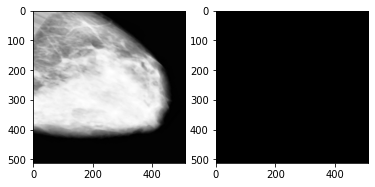

In [ ]:

seed=24
batch_size= 8


from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True)

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True) #Binarize the output again. 

# #Original pixel values are 0 and 255. So rescaling to 0 to 1,     rotation_range=90,shear_range=0.5,
#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network
#rescale = 1/255.,width_shift_range=0.3,height_shift_range=0.3,

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/train_images/", 
                                                    seed=seed, batch_size=batch_size,target_size=(512,512),color_mode = 'grayscale',
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/train_masks/", 
                                                         seed=seed,
                                                         batch_size=batch_size,target_size=(512,512),
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/val_images/", 
                                                               seed=seed,
                                                               batch_size=batch_size, target_size=(512,512),color_mode = 'grayscale',
                                                               class_mode=None) #Default batch size 32, if not specified here

valid_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/val_masks/", 
                                                               seed=seed,
                                                               batch_size=batch_size, target_size=(512,512),
                                                               color_mode ='grayscale',  #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)


# Sanity check to ensure the "generated "images and masks are aligned #


x = image_generator.next()
y = mask_generator.next()
image = x[0]
mask = y[0]
plt.subplot(1,2,1)
plt.imshow(image[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0], cmap='gray')
plt.show()


# **Compile and Train the Model using Data Augmentation**

512
512
1


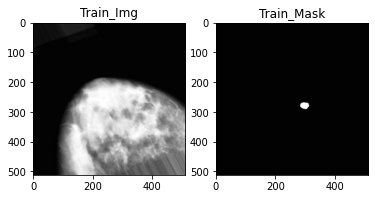

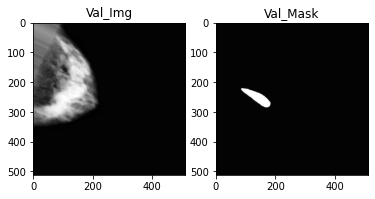

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 512, 512, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 512, 512, 16) 0           conv2d_171[0][0]                 
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 512, 512, 16) 2320        dropout_81[0][0]                 
____________________________________________________________________________________________

In [ ]:
#### Training-- Model Compile, Fit ####

IMG_HEIGHT =  x.shape[1]
print(IMG_HEIGHT)
IMG_WIDTH  =  x.shape[2]
print(IMG_WIDTH)
IMG_CHANNELS= x.shape[3]
print(IMG_CHANNELS)

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

X_train = image_generator.next()
y_train = mask_generator.next()
X_val = valid_img_generator.next()
y_val = valid_mask_generator.next()


train_image = X_train[0]
train_mask = y_train[0]
plt.subplot(1,2,1)
plt.title("Train_Img")
plt.imshow(train_image[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Train_Mask")
plt.imshow(train_mask[:,:,0], cmap='gray')
plt.show()

val_image = X_val[0]
val_mask = y_val[0]
plt.subplot(1,2,1)
plt.title("Val_Img")
plt.imshow(val_image[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Val_Mask")
plt.imshow(val_mask[:,:,0], cmap='gray')
plt.show()



#Experiment with various loss functions and accuracy metrics

#Jaccard distance loss mimics IoU. 

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

###Compile Options####

#STANDARD BINARY CROSS ENTROPY AS LOSS AND ACCURACY AS METRIC
#model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#JACCARD LOSS AND DICE METRIC 
#model.compile(optimizer=Adam(learning_rate=1e-3), loss=jaccard_distance_loss, metrics=[dice_metric])

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.

!pip install focal-loss 
from focal_loss import BinaryFocalLoss
import tensorflow.python.keras.backend as K

model.compile(optimizer=Adam(learning_rate= 1e-3), loss=BinaryFocalLoss(gamma=2), metrics=[dice_metric])


model.summary()

#######  TRAIN ##################

batch_size=8
num_train_imgs = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/train_images/train'))
print(num_train_imgs)
num_val_imgs=len(os.listdir('/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/val_images/val'))
print(num_val_imgs)
steps_per_epoch = num_train_imgs //batch_size
print(steps_per_epoch)


#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint("BC_Seg_Unet_DataAug_focal_10ep.hdf5", verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



history=model.fit(train_generator, validation_data=val_generator,batch_size =batch_size,verbose=1,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=25, shuffle=False, callbacks=callbacks)

# history = model.fit(, validation_data=val_generator, 
#                     steps_per_epoch=steps_per_epoch, 
#                     validation_steps=steps_per_epoch, epochs=50, callbacks=callbacks)


model.save('BC_Seg_Unet_DataAug_focal_25ep.hdf5')


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('FOCAL loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_metric']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_metric']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


for batch in datagen.flow(x, batch_size=1, seed=1337):
      # batch...


## **Model Testing and Evaluation -IOU, Dice etc**

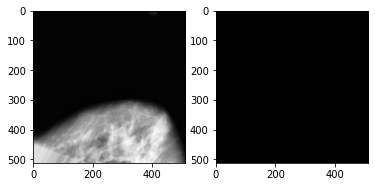

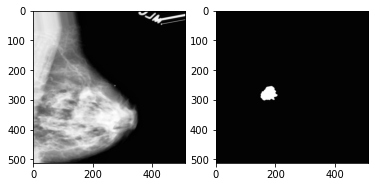

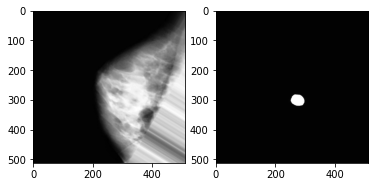

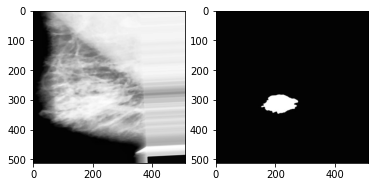

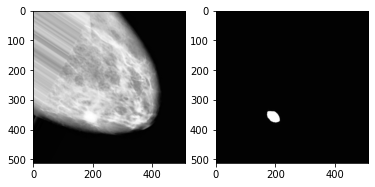

In [ ]:
############# Model Testing and Evaluation########

#Test the model on images we held out for testing.
#We can use the generator again for predictions. This is only using augmentaton to load images from the drive, perfomr augmentation and predict. 

seed=24

from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/UNet_ImgGen_Data5_focal_dice_chkpoint_btsz8_2_epochs.hdf5", compile=False)

test_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/test_images/", 
                                                              seed=seed,target_size=(512, 512), 
                                                              batch_size=32, color_mode = 'grayscale',
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/BC_Tumor_Segmentation_data/data2/data5/test_masks/", 
                                                              seed=seed, target_size=(512, 512),
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

### Testing on a few test images

a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)  # Predict

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.squeeze(test_img))   # reduces the dimension for display to 2D
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average
 
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)
    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    

# **Model Predict**

In [ ]:
###prediction code###  ref https://github.com/unbox-research/transfer-learning-blog/blob/master/image_demo.py

guacomole = read_file('guac.jpg')
plt.imshow(guacomole.reshape(224,224,3))
plt.show()

preds = InceptionV3().predict(guacomole)
print(preds)
print(preds.max())
print(preds.argmax(-1))  # Indeed, it got this right!
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a  # Image net class labels.

# **Classification of the lesion**

In [ ]:
#### Pending ###

# Model Enhancement using Transfer Learning and Pretrained VGG16 backbone

In [ ]:
## Pending##